### Overview

This notebook creates a NN following Toms et al. 
It expands on Toms et al. to predict El Nino or La Nina at a specified lead time using SST anomalies only in the extratropics and applies LRP to determine the input that contributed to the prediction.  

### Imports

In [1]:
import xarray as xr
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

### Functions

In [2]:
def detrend(da):
    da.values[np.isnan(da.values)] = 0.0
    return signal.detrend(da,axis=0)  

### Read Data, Select times, Reverse lats

In [3]:
fname = '/scratch/kpegion/sst.mon.mean.COBE.nc'
ds = xr.open_dataset(fname,decode_times=True).sel(time=slice('1948-01','2017-12'))
ds=ds.reindex(lat=list(reversed(ds['lat'])))
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 840)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2017-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    title:            created 12/2013 from data provided by JRA
    history:          Created 12/2012 from data obtained from JRA by ESRL/PSD
    platform:         Analyses
    citation:         Hirahara, S., Ishii, M., and Y. Fukuda,2014: Centennial...
    institution:      NOAA ESRL/PSD
    Conventions:      CF-1.2
    dataset_title:    COBE-SST2 Sea Surface Temperature and Ice
    original_source:  https://climate.mri-jma.go.jp/pub/ocean/cobe-sst2/
    References:       http://www.psl.noaa.gov/data/gridded/cobe2.html

### Make anomalies

In [4]:
ds_climo = ds.sel(time=slice('1980-01','2009-12')).groupby('time.month').mean(dim='time')
ds_anom = ds.groupby('time.month') - ds_climo

### Detrend and put back into `xr.Dataset`

In [5]:
anoms_detrend = detrend(ds_anom['sst'])

ds_tmp=xr.DataArray(anoms_detrend,
                    coords={'time':ds['time'],
                            'lat':ds['lat'],
                            'lon': ds['lon']},
                    dims=['time','lat','lon'])        
ds_anom_detrend=ds_tmp.to_dataset(name='sst')
ds_anom_detrend

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 840)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2017-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.001705 0.00159 0.001998

### Extract the Extratropics

In [6]:
ds_nhet=ds_anom_detrend.sel(lat=slice(15,90))
ds_shet=ds_anom_detrend.sel(lat=slice(-90,-15))
ds_et=xr.concat([ds_shet,ds_nhet],dim='lat')
ds_et

<xarray.Dataset>
Dimensions:  (lat: 150, lon: 360, time: 840)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2017-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    sst      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.001705 0.00159 0.001998

### Make Nino3.4

In [7]:
ds_nino = ds_anom_detrend.sel(lat=slice(-5,5),lon=slice(360-170,360-120)).mean(dim=['lat','lon'])
ds_nino

<xarray.Dataset>
Dimensions:  (time: 840)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2017-12-01
Data variables:
    sst      (time) float32 0.2419 0.6627 0.5717 ... -0.5673 -0.7928 -1.138

### Split Train and Test

In [8]:
# Get the years for the Predictors (aka Features)
sst_anom_train=ds_et.sel(time=slice('1948-01','2003-12'))
sst_anom_test=ds_et.sel(time=slice('2004-01','2017-12'))

# Extract only El Nino and La Nina Events
sst_anom_train=sst_anom_train['sst'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
sst_anom_test=sst_anom_test['sst'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')

# Get the years for the Predictand
nino_train=ds_nino.sel(time=slice('1948-01','2003-12'))
nino_test=ds_nino.sel(time=slice('2004-01','2017-12'))

# Select only El Nino and La nina Events
nino_train=nino_train['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
nino_test=nino_test['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')

### Get dimensions for use later

In [9]:
nx=len(ds_et['lon'])
ny=len(ds_et['lat'])
nt=len(ds_et['time'])
print(nx,ny,nt)

360 150 840


### Turn into categorization problem with 1's and 0's for warm and cold events

In [10]:
# Predictors ( aka Features ): Training on first nt_train months 
X_train=sst_anom_train.values

# Create output vector based as a Categorical Predictand El Nino = [True,False] and La Nina = [False,True]
l_warm_train = ( nino_train > 0.5 )
l_cold_train = ( nino_train < -0.5 )
y_train = np.array([l_warm_train,l_cold_train]).T

# Get dimensions of training data
nt_train,junk=y_train.shape
y_train.shape

(361, 2)

### Set Y for prediction problem

In [11]:
#nmon=1
nmon=9
y_train=y_train[nmon:nt_train,:]
X_train=X_train[0:nt_train-nmon,:,:]
nt_train=nt_train-nmon

In [12]:
print(X_train.shape,y_train.shape, nt_train)

(352, 150, 360) (352, 2) 352


In [13]:
print("El Nino TRAIN: ",l_warm_train[l_warm_train==True].count().values)
print("La Nina TRAIN: ",l_cold_train[l_cold_train==True].count().values)

El Nino TRAIN:  177
La Nina TRAIN:  184


### Make a keras model

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


In [15]:
model = Sequential()

model.add(Dense(8, input_dim=nx*ny,activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(25),
                bias_initializer='he_normal'))

model.add(Dense(8, activation='relu',
                kernel_initializer='he_normal',
                bias_initializer='he_normal',
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.001,nesterov=True,momentum=0.9))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the NN

In [16]:
XX = X_train.reshape(nt_train,nx*ny)
model.fit(XX, y_train, epochs=100, batch_size=10)

Epoch 1/100
352/352 [==============================] - 1s 1ms/step - loss: 47.5558 - acc: 0.5398
Epoch 2/100
352/352 [==============================] - 0s 705us/step - loss: 1.0859 - acc: 0.5994
Epoch 3/100
352/352 [==============================] - 0s 986us/step - loss: 0.9724 - acc: 0.5966
Epoch 4/100
352/352 [==============================] - 0s 1ms/step - loss: 0.9337 - acc: 0.6136
Epoch 5/100
352/352 [==============================] - 0s 968us/step - loss: 0.9366 - acc: 0.6392
Epoch 6/100
352/352 [==============================] - 0s 874us/step - loss: 0.9629 - acc: 0.5739
Epoch 7/100
352/352 [==============================] - 0s 888us/step - loss: 0.9042 - acc: 0.5881
Epoch 8/100
352/352 [==============================] - 0s 923us/step - loss: 0.9263 - acc: 0.6534
Epoch 9/100
352/352 [==============================] - 0s 967us/step - loss: 0.8991 - acc: 0.5994
Epoch 10/100
352/352 [==============================] - 0s 1ms/step - loss: 0.9528 - acc: 0.5710
Epoch 11/100
352/352 [==

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 432008    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 432,098
Trainable params: 432,098
Non-trainable params: 0
_________________________________________________________________


In [18]:
# evaluate the keras model
_, accuracy = model.evaluate(XX, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

352/352 [==============================] - 0s 310us/step
Training Accuracy: 71.59


### Test the Model Accuracy using Test Data
Need to setup for N-month lead

In [19]:
# Predictors ( aka Features )
X_test=sst_anom_test.values

# Select El Nino and La Nina (Categorical Predictand)
l_warm_test = ( nino_test > 0.5 )
l_cold_test = ( nino_test < -0.5 )
y_test = np.array([l_warm_test,l_cold_test]).T

nt_test,junk=y_test.shape

y_test.shape

(95, 2)

In [20]:
#nmon=1
nmon=12
y_test=y_test[nmon:nt_test,:]
X_test=X_test[0:nt_test-nmon,:,:]
nt_test=nt_test-nmon

In [21]:
XX_test = X_test.reshape(nt_test,nx*ny)
XX_test[np.isnan(XX_test)] = 0.0

In [22]:
print(XX_test.shape, y_test.shape)

(83, 54000) (83, 2)


In [23]:
_, test_accuracy = model.evaluate(XX_test, y_test)
print('Testing Accuracy: %.2f' % (test_accuracy*100))

83/83 [==============================] - 0s 219us/step
Testing Accuracy: 34.94


### Apply `iNNvestigate` using all El Nino and La Nina Cases as Input

In [24]:
import innvestigate
import innvestigate.utils

In [25]:
# Predictors ( aka Features ): Training on first nt_train months 
X=ds_et['sst'][0:nt,:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all').values
nt_new,ny,nx=X.shape
X=X.reshape(nt_new,nx*ny)
print(nt_new)

# Select El Nino and La Nina (Categorical Predictand)
y=ds_nino['sst'].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')
l_warm = ( y > 0.5 )
l_cold = ( y < -0.5 )
y = np.array([l_warm,l_cold]).T

y.shape

456


(456, 2)

In [26]:
print(X.shape)

(456, 54000)


In [27]:
print("El Nino ALL: ",l_warm[l_warm==True].count().values)
print("La Nina ALL: ",l_cold[l_cold==True].count().values)

El Nino ALL:  220
La Nina ALL:  236


In [28]:
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(X)

In [29]:
a.shape

(456, 54000)

### Get El Nino Cases, Reshape to `time,lat,lon`

In [30]:
# Get El Nino Cases
a_warm=a[l_warm==True,:]

# Reshape to time,lat,lon
tmp=a_warm.shape
a=a_warm.reshape((tmp[0],ny,nx))

# Find times corresponding to El Nino
ds_time=ds_anom_detrend['sst'][0:nt,:,:].where(np.abs(ds_nino['sst'])>0.5).dropna(dim='time',how='all')['time'][l_warm==True]

### Make `xarray.Dataset`

In [31]:
ds_tmp=xr.DataArray(a,
                    coords={'time':ds_time,
                            'lat':ds_et['lat'].values,
                            'lon': ds_et['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp=ds_tmp.to_dataset(name='warm')
ds_lrp

<xarray.Dataset>
Dimensions:  (lat: 150, lon: 360, time: 220)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-01 1948-03-01 ... 2016-05-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -0.0

### Normalize by max value in grid for each input

In [32]:
ds_lrp=ds_lrp/ds_lrp.max(dim=['lat','lon'])
ds_lrp

<xarray.Dataset>
Dimensions:  (lat: 150, lon: 360, time: 220)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-01 1948-03-01 ... 2016-05-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 -0.0

### Plot Composite Relevance for N-month prediction

In [33]:
from cartopy.util import add_cyclic_point

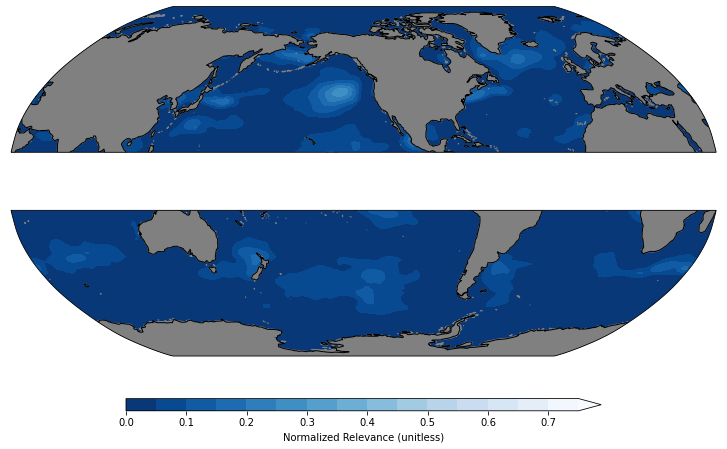

In [34]:
ds_plot_nh=ds_lrp.sel(lat=slice(15,90))
ds_plot_sh=ds_lrp.sel(lat=slice(-90,-15))

clevs=np.arange(0.0,0.8,.05)

fig, ax = plt.subplots(nrows=2,ncols=1,
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=230)},
                       figsize=(11,8.5))

# Northern Hemisphere
data, lons = add_cyclic_point(ds_plot_nh['warm'].mean(dim='time'), 
                              coord=ds_plot_nh['lon'])
cs=ax[0].contourf(lons, ds_plot_nh['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax[0].add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax[0].coastlines()

# Southern Hemisphere
data, lons = add_cyclic_point(ds_plot_sh['warm'].mean(dim='time'), 
                              coord=ds_plot_nh['lon'])
cs=ax[1].contourf(lons, ds_plot_sh['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax[1].add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                            edgecolor='gray', facecolor='gray'))
ax[1].coastlines()

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,
                  orientation='horizontal',
                  label='Normalized Relevance (unitless)')

plt.savefig('../figs/lrp_compET_elnino_COBE_lead'+str(nmon)+'months.png')

### Plot LRP composite by season

Text(0.5, 0.98, 'Northern Hemisphere: 12months Lead')

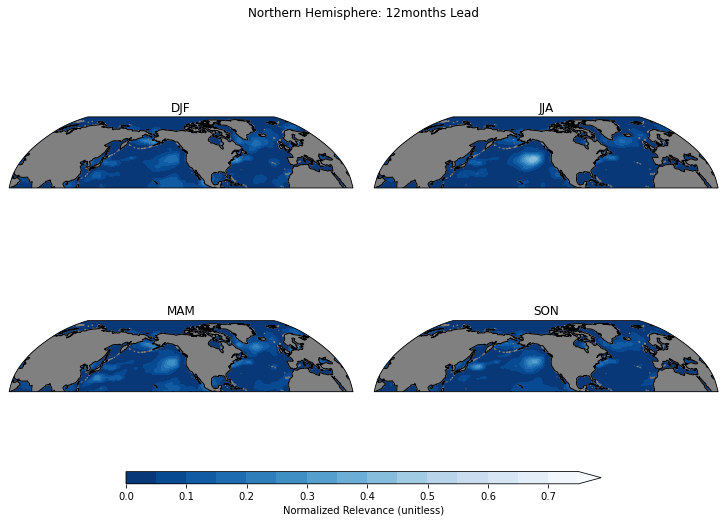

In [38]:
ds_seas=ds_lrp.groupby('time.season').mean(dim='time').sel(lat=slice(15,90))

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=230)},
                        figsize=(11,8.5))

axs=axs.flatten()

#Loop over all of the seasons and plot
for i,seas in enumerate(ds_seas['season']):

        # Select the season
        data=ds_seas['warm'].sel(season=seas)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_seas['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_seas['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='Blues_r',extend='max')
        
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                                       edgecolor='gray', facecolor='gray'))
        axs[i].coastlines()
        
        # Title each subplot with the name of the season
        axs[i].set_title(seas.values)


# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,
                  orientation='horizontal',
                  label='Normalized Relevance (unitless)')

# Add a big title at the top
plt.suptitle('Northern Hemisphere: '+str(nmon)+'months Lead')

Text(0.5, 0.98, 'Southern Hemisphere: 12months Lead')

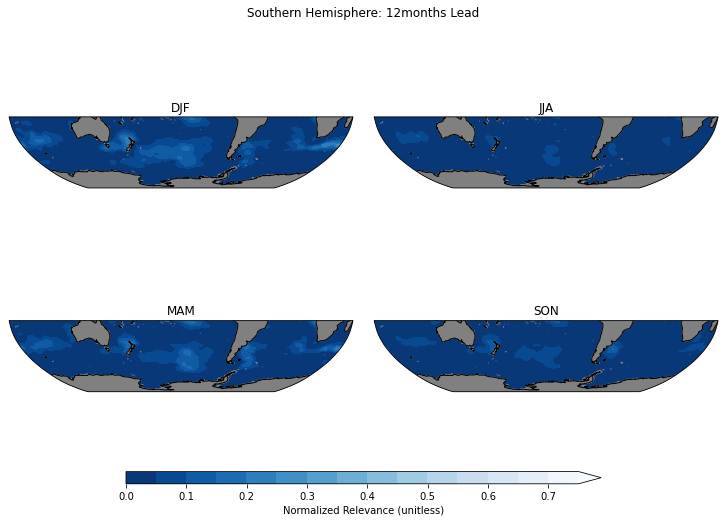

In [39]:
ds_seas=ds_lrp.groupby('time.season').mean(dim='time').sel(lat=slice(-90,15))

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=230)},
                        figsize=(11,8.5))

axs=axs.flatten()

#Loop over all of the seasons and plot
for i,seas in enumerate(ds_seas['season']):

        # Select the season
        data=ds_seas['warm'].sel(season=seas)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds_seas['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds_seas['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='Blues_r',extend='max')
        
        axs[i].add_feature(cfeature.NaturalEarthFeature('physical','land','50m', 
                                                       edgecolor='gray', facecolor='gray'))
        axs[i].coastlines()
        
        # Title each subplot with the name of the season
        axs[i].set_title(seas.values)


# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,
                  orientation='horizontal',
                  label='Normalized Relevance (unitless)')

# Add a big title at the top
plt.suptitle('Southern Hemisphere: '+str(nmon)+'months Lead')